In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/Users/winirrr/Documents/EventBased_Project/exp_data/exp_0_df.csv')

def normalize_events(timestamps, x, y, polarity, resolution):
    sensor_height, sensor_width = resolution

    min_t, max_t = timestamps.min(), timestamps.max()
    timestamps = (timestamps - min_t) / (max_t - min_t)  # Normalize to [0, 1]

    x = x / sensor_width
    y = y / sensor_height

    return timestamps, x, y, polarity

# Extract relevant information
timestamps = df['timestamp'].values
x = df['x'].values
y = df['y'].values
polarity = df['polarity'].values
labels = df['labels'].values

# Normalize the events
resolution = (640, 480)  # Example resolution, adjust as needed
timestamps, x, y, polarity = normalize_events(timestamps, x, y, polarity, resolution)

In [2]:
import numpy as np

def generate_input_current_from_events(timestamps, I_0, tau_s, T, dt):
    time = np.arange(0, T, dt)
    I = np.zeros_like(time)
    
    for t_event in timestamps:
        spike_time_index = int(t_event * T / dt)
        I[spike_time_index:] += I_0 * np.exp(-(time[spike_time_index:] - t_event * T) / tau_s)
    
    return lambda t: I[int(t / dt)], time, I

# Parameters for the input current generation
I_0 = 1.0  # Peak current amplitude
tau_s = 5  # Synaptic time constant (in ms)
T = 1.0  # Total simulation time in seconds
dt = 0.001  # Time step in seconds

I_func, time, I = generate_input_current_from_events(timestamps, I_0, tau_s, T, dt)


In [3]:
class LIFNeuron:
    def __init__(self, tau_m, V_rest, V_thresh, V_reset, R, dt):
        self.tau_m = tau_m
        self.V_rest = V_rest
        self.V_thresh = V_thresh
        self.V_reset = V_reset
        self.R = R
        self.dt = dt
        self.V = V_rest
        self.spike_times = []

    def update(self, I, t):
        dV = (-(self.V - self.V_rest) + self.R * I) * (self.dt / self.tau_m)
        self.V += dV

        if self.V >= self.V_thresh:
            self.V = self.V_reset
            self.spike_times.append(t)
    
    def simulate(self, I_func, T):
        time = np.arange(0, T, self.dt)
        V_trace = []
        for t in time:
            I = I_func(t)
            self.update(I, t)
            V_trace.append(self.V)
        return time, np.array(V_trace), self.spike_times

# Create an LIF neuron
neuron = LIFNeuron(tau_m=20, V_rest=-65, V_thresh=-50, V_reset=-70, R=10, dt=dt)

# Simulate the neuron
time, V_trace, spike_times = neuron.simulate(I_func, T)


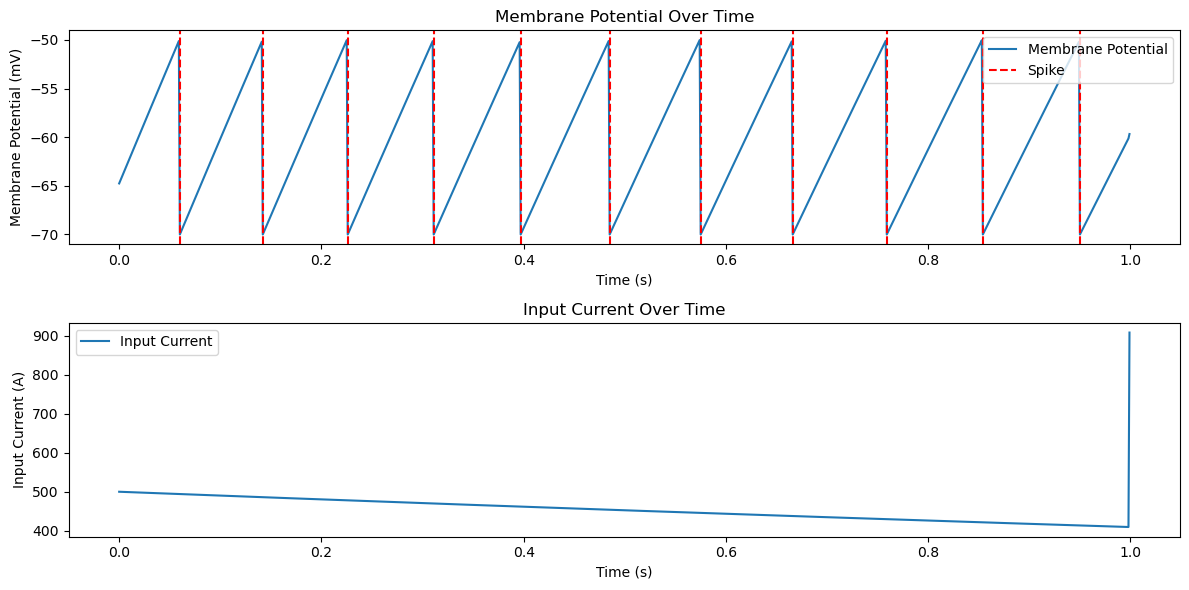

In [4]:
import matplotlib.pyplot as plt

# Plot membrane potential over time
plt.figure(figsize=(12, 6))

# Subplot for membrane potential
plt.subplot(2, 1, 1)
plt.plot(time, V_trace, label='Membrane Potential')
for spike_time in spike_times:
    plt.axvline(spike_time, color='r', linestyle='--', label='Spike' if spike_time == spike_times[0] else "")
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential Over Time')
plt.legend()

# Subplot for input current
plt.subplot(2, 1, 2)
plt.plot(time, I, label='Input Current')
plt.xlabel('Time (s)')
plt.ylabel('Input Current (A)')
plt.title('Input Current Over Time')
plt.legend()

plt.tight_layout()
plt.show()
